In [ ]:
!pip install datasets wandb dataclasses typing pandas torch transformers jiwer sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 16.6 MB/s 
     |████████████████████████████████| 1.8 MB 88.6 MB/s 
     |████████████████████████████████| 78 kB 5.0 MB/s 
     |████████████████████████████████| 4.4 MB 51.5 MB/s 
     |████████████████████████████████| 1.2 MB 78.1 MB/s 
     |████████████████████████████████| 140 kB 79.4 MB/s 
     |████████████████████████████████| 1.1 MB 86.7 MB/s 
     |████████████████████████████████| 212 kB 90.0 MB/s 
     |████████████████████████████████| 101 kB 13.9 MB/s 
     |████████████████████████████████| 596 kB 55.4 MB/s 
     |████████████████████████████████| 127 kB 95.6 MB/s 
     |████████████████████████████████| 181 kB 61.0 MB/s 
     |████████████████████████████████| 145 kB 88.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 6.6 MB 68.2 MB/s 
     |█████████████████████████████

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from datasets import load_metric, load_dataset
import torch
from transformers import (
    TrOCRProcessor,
    AutoFeatureExtractor,
    AutoTokenizer,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator,
    HfArgumentParser,
    EarlyStoppingCallback
)
import wandb
from dataclasses import dataclass, field
from typing import Optional
import os
from torch.utils.data import Dataset
import pandas as pd

In [ ]:
class OCRDataset(Dataset):
    def __init__(self, df, processor, transforms=lambda x:x, max_target_length=128):
        self.df = df
        self.processor = processor
        self.transforms = transforms
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        #file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = self.df['image'][idx].convert("RGB")
        image = self.transforms(image)
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
encoder = "facebook/deit-small-distilled-patch16-224"
decoder = "UBC-NLP/MARBERTv2"
model_name = None # "microsoft/trocr-large-handwritten"

In [ ]:
training_args = Seq2SeqTrainingArguments(
        predict_with_generate=True,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        per_device_train_batch_size= 8, #train_args.per_device_train_batch_size,
        per_device_eval_batch_size= 8, #train_args.per_device_eval_batch_size,
        fp16=True,
        adam_beta1=0.9,
        adam_beta2=0.999,
        adam_epsilon=1e-08,
        num_train_epochs=5, #train_args.num_train_epochs,
        weight_decay=0.005,
        learning_rate=5e-3, #train_args.learning_rate,
        seed=42,
        report_to="wandb",
        load_best_model_at_end=True,
        metric_for_best_model="cer",
        greater_is_better=False, 
        do_train=True,
        do_eval=True,
        do_predict=True,
        output_dir = "./"#train_args.output_dir,
    )

In [ ]:
dataset = load_dataset(
        "gagan3012/adab"
)

Downloading:   0%|          | 0.00/930 [00:00<?, ?B/s]

Using custom data configuration gagan3012--adab-8162139264bfb833


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/gagan3012___parquet/gagan3012--adab-8162139264bfb833/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 13525
    })
    valid: Dataset({
        features: ['image', 'text'],
        num_rows: 751
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 752
    })
})

In [ ]:
if model_name is None:
    tokenizer = AutoTokenizer.from_pretrained(decoder)
    feature_extractor = AutoFeatureExtractor.from_pretrained(encoder)
    processor = TrOCRProcessor(feature_extractor, tokenizer)
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder, decoder)

else:
    processor = TrOCRProcessor.from_pretrained(model_name)
    model = VisionEncoderDecoderModel.from_pretrained(model_name)

    #fn_kwargs = dict(
    #    processor = processor,
    #)
    #df = dataset.map(preprocess,fn_kwargs=fn_kwargs,remove_columns=["id"])

df_train = pd.DataFrame(dataset['train'])
df_eval = pd.DataFrame(dataset['valid'])
df_pred = pd.DataFrame(dataset['test'])

df_train = df_train.sample(frac=1)
df_eval = df_eval.sample(frac=1)
df_pred = df_pred.sample(frac=1)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)
df_pred.reset_index(drop=True, inplace=True)


transformer = lambda x: x 

train_dataset = OCRDataset(df=df_train, 
                           processor=processor, 
                           max_target_length=128, 
                           transforms=transformer)

eval_dataset = OCRDataset(df=df_eval,
                          processor=processor,
                          max_target_length=128,
                          transforms=transformer)

predict_dataset = OCRDataset(df=df_pred, 
                             processor=processor, 
                             max_target_length=128,
                             transforms=transformer)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Eval dataset size: {len(eval_dataset)}")
print(f"Predict dataset size: {len(predict_dataset)}")

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Downloading:   0%|          | 0.00/439 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/deit-small-distilled-patch16-224 were not used when initializing DeiTModel: ['cls_classifier.bias', 'distillation_classifier.weight', 'distillation_classifier.bias', 'cls_classifier.weight']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-small-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

Downloading:   0%|          | 0.00/757 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at UBC-NLP/MARBERTv2 were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['bert.encoder.layer.6.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.3.crossattention.output.dense.weight', 'bert.encoder.layer.7.crossattention.self.query.bias', 'bert.encoder.layer.4.crossattention.self.query.weight', 'bert.e

Train dataset size: 13525
Eval dataset size: 751
Predict dataset size: 752


In [ ]:
cer_metric = load_metric("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
trainer = Seq2SeqTrainer(
        model=model,
        tokenizer=processor.feature_extractor,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=default_data_collator,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

Using cuda_amp half precision backend


In [ ]:

print("Training model")
train_result = trainer.train()
metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()
print("Evaluating model")
metrics = trainer.evaluate(metric_key_prefix="eval")
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)
print("Predicting")
predict_results = trainer.predict(
    predict_dataset,
    metric_key_prefix="predict",
)
metrics = predict_results.metrics

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

if trainer.is_world_process_zero():
    if training_args.predict_with_generate:
        predictions = processor.batch_decode(
            predict_results.predictions,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True,
        )
        predictions = [pred.strip() for pred in predictions]
        output_prediction_file = os.path.join(
            "./", "generated_predictions.txt"
        )
        print(predictions)
        with open(output_prediction_file, "w") as writer:
            writer.write("\n".join(predictions))

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13525
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8455
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training model


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Cer
1,12.547700,nan,1.000000
2,0.000000,nan,1.000000
3,0.000000,nan,1.000000
4,0.000000,nan,1.000000


***** Running Evaluation *****
  Num examples = 751
  Batch size = 8
Saving model checkpoint to ./checkpoint-1691
Configuration saved in ./checkpoint-1691/config.json
Model weights saved in ./checkpoint-1691/pytorch_model.bin
Feature extractor saved in ./checkpoint-1691/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 751
  Batch size = 8
Saving model checkpoint to ./checkpoint-3382
Configuration saved in ./checkpoint-3382/config.json
Model weights saved in ./checkpoint-3382/pytorch_model.bin
Feature extractor saved in ./checkpoint-3382/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 751
  Batch size = 8
Saving model checkpoint to ./checkpoint-5073
Configuration saved in ./checkpoint-5073/config.json
Model weights saved in ./checkpoint-5073/pytorch_model.bin
Feature extractor saved in ./checkpoint-5073/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 751
  Batch size = 8
Saving model checkpoint to ./checkpoint-676

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 6199012669GF
  train_loss               =       3.1369
  train_runtime            =   0:42:22.71
  train_samples_per_second =       26.596
  train_steps_per_second   =        3.325
Evaluating model


***** Running Prediction *****
  Num examples = 752
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_cer                =        1.0
  eval_loss               =        nan
  eval_runtime            = 0:00:24.03
  eval_samples_per_second =     31.245
  eval_steps_per_second   =      3.911
Predicting
***** predict metrics *****
  predict_cer                =        1.0
  predict_loss               =        nan
  predict_runtime            = 0:00:23.94
  predict_samples_per_second =     31.409
  predict_steps_per_second   =      3.926
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

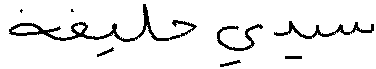

In [ ]:
image =  df_pred['image'][4]
image

In [ ]:
df_pred['text'][4]

'سيدي خليفة'

In [ ]:
predictions[3]

''